<a href="https://colab.research.google.com/github/2pterons/multicampus/blob/main/KoGPT2_naver_movie(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# KoGPT2를 이용한 네이버 영화 감성분석
!pip install --upgrade mxnet>=1.6.0
!pip install gluonnlp
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 344 kB 9.7 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595735 sha256=96572f35847dfe5d8f20a8f86ee243ca4c9713e98a211771e272a6afc9438645
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp
     |████████████████████████████████| 2.8 MB 7.4 MB/s 
     |████████████████████████████████| 636 kB 66.7 MB/s 
     |████████████████████████████████| 3.3 MB 64.9 MB/s 
     |████████████████████████████████| 895 kB 63.7 MB/s 
     |████████████████████████████████| 50 kB 8.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 8.2 MB/s 


In [ ]:
import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer, SentencepieceDetokenizer
from transformers import TFGPT2LMHeadModel
import tensorflow as tf

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Commented out IPython magic to ensure Python compatibility.
%cd /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data/
import pickle
with open('final_idiom_dataset_for_ko.pkl', 'rb') as f:
  text = pickle.load(f)

/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/data


In [ ]:
data = text['ko']
data.head()

0    다만 지난 7월부터 수면 무호흡증 진단을 위한 수면다원검사와 치료에 필요한 양압기 ...
1                  하지만 몇몇 사람들은 그 표현이 관용구인지 알아차리지 못합니다.
2    끈끈한 승부근성으로 찬스에서 더 영양가 만점의 활약을 하는 오재원이 있기에 선두질주...
3    협약내용은 삼성화재서비스손해사정㈜에서 매월 임직원들의 기부를 통해 향후 3년간 30...
4                  이 같은 대중적 관심을 겨냥해 이동통신사가 발 빠르게 움직였다.
Name: ko, dtype: object

In [ ]:
target = text['Label']
target.head()

0    0
1    0
2    1
3    0
4    1
Name: Label, dtype: int64

50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5
['<s>', '▁양반', '김', '은', '▁한국', '▁수출', '품', '▁중', '▁상위', '▁세', '▁손가락', '▁안에', '▁드는', '▁틈새', '시장의', '▁숨은', '▁강', '자', '이에요', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________
Model: "tfgp_t2lm_head_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got c

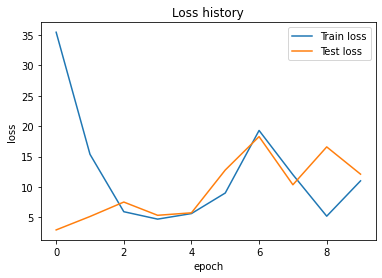


Accuracy = 46.00 %


In [ ]:

dx_train,dx_test, dy_train, dy_test = train_test_split(data, target, test_size=0.2, stratify=target, random_state=42)

MY_PATH = '/content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/'
MODEL_PATH = MY_PATH + 'gpt_ckpt'
TOKENIZER_PATH = MY_PATH + 'gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH, num_best=0, alpha=0)
detokenizer = SentencepieceDetokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token = None,
                                               sep_token = None,
                                               cls_token = None,
                                               unknown_token = '<unk>',
                                               padding_token = '<pad>',
                                               bos_token = '<s>',
                                               eos_token = '</s>')
# vocab --> Vocab(size=50000, unk="<unk>", reserved="['<pad>', '<s>', '</s>']")

MAX_LEN = 60

def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]  
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)

# 시험용으로 100개씩만 사용한다.
x_train, y_train = build_data(dx_train[:100], dy_train[:100])
x_test, y_test = build_data(dx_test[:100], dy_test[:100])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_test[0]

len(x_test[0])

print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])

word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]

# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()

#pre-trainmodel
# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = False
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0

# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)

# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]

# Downstream task : 네이버 영화 감성분석
# -------------------------------------
# 사전학습데이터 없이 Dense Layer만 붙여놓은것
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001))
model.summary()

hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=10, batch_size=32)

# 1/1 [==============================] - 14s 14s/step - loss: 0.7251 - val_loss: 70.8553
# Epoch 2/3
# 1/1 [==============================] - 1s 1s/step - loss: 69.2513 - val_loss: 26.5999
# Epoch 3/3
# 1/1 [==============================] - 1s 1s/step - loss: 25.5047 - val_loss: 21.4767

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()
print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

# gpt_model.trainable = True로 바꾸고, learning-rate를 작게 적용해서
# 전체를 다시 학습한다. (미세 조정)

In [ ]:
MAX_LEN = 60

def build_data(x_data, y_label):
    data_sents = []
    data_labels = []

    for sent, label in zip(x_data, y_label):
        tokenized_text = vocab[tokenizer(sent)]

        tokens = [vocab[vocab.bos_token]]  
        tokens += pad_sequences([tokenized_text], 
                                MAX_LEN, 
                                value=vocab[vocab.padding_token], 
                                padding='post').tolist()[0] 
        tokens += [vocab[vocab.eos_token]]

        data_sents.append(tokens)
        data_labels.append(label)

    return np.array(data_sents, dtype=np.int64), np.array(data_labels, dtype=np.int64).reshape(-1, 1)


In [ ]:
# 시험용으로 100개씩만 사용한다.
x_train, y_train = build_data(dx_train[:100], dy_train[:100])
x_test, y_test = build_data(dx_test[:100], dy_test[:100])

x_train.shape, y_train.shape, x_test.shape, y_test.shape

x_test[0]

len(x_test[0])


62

In [ ]:
print(len(vocab))
print(vocab.padding_token, ':', vocab[vocab.padding_token])
print(vocab.bos_token, ': ', vocab[vocab.bos_token])
print(vocab.eos_token, ': ', vocab[vocab.eos_token])
print(vocab.unknown_token, ': ', vocab[vocab.unknown_token])


50000
<pad> : 3
<s> :  0
</s> :  1
<unk> :  5


In [ ]:
word2idx = {k:v for k, v in vocab.token_to_idx.items()}
idx2word = {v:k for k, v in word2idx.items()}
idx2word[5000]

# 참고 : https://nlp.gluon.ai/api/modules/data.html
tokenizer('나는 자연어처리를 공부하고 있다')

print([idx2word[i] for i in x_test[0]])

gpt_model = TFGPT2LMHeadModel.from_pretrained(MODEL_PATH)
gpt_model.summary()

# TFGPT2MainLayer는 fine-tuning을 하지 않는다.
gpt_model.trainable = False
gpt_model.summary() # gtp_model을 다시 확인한다. trainable params = 0


['<s>', '▁양반', '김', '은', '▁한국', '▁수출', '품', '▁중', '▁상위', '▁세', '▁손가락', '▁안에', '▁드는', '▁틈새', '시장의', '▁숨은', '▁강', '자', '이에요', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '</s>']


All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at /content/drive/MyDrive/Colab Notebooks/multicampus/Idiom Classifier/4.KoGPT2/gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 124,242,432
Non-trainable params: 0
_________________________________________________________________
Model: "tfgp_t2lm_head_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
transformer (TFGPT2MainLayer multiple                  124242432 
Total params: 124,242,432
Trainable params: 0
Non-trainable params: 124,242,432
_________________________________________________________________


In [ ]:

# GPT2 입력
# ---------
x_input = Input(batch_shape = (None, MAX_LEN + 2), dtype = tf.int32)

# GPT2 출력
# ---------
# output_gpt[0]        --> <KerasTensor: shape=(None, 60, 50000) dtype=float32
# output_gpt[0][:, -1] --> <KerasTensor: shape=(None, 50000) dtype=float32
output_gpt = gpt_model(x_input)[0][:, -1]


In [ ]:

# Downstream task : 네이버 영화 감성분석
# -------------------------------------
y_output = Dense(1, activation = 'sigmoid')(output_gpt)
model = Model(x_input, y_output)
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001))
model.summary()

hist = model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs=3, batch_size=1024)

# 1/1 [==============================] - 14s 14s/step - loss: 0.7251 - val_loss: 70.8553
# Epoch 2/3
# 1/1 [==============================] - 1s 1s/step - loss: 69.2513 - val_loss: 26.5999
# Epoch 3/3
# 1/1 [==============================] - 1s 1s/step - loss: 25.5047 - val_loss: 21.4767


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 62)]              0         
_________________________________________________________________
tfgp_t2lm_head_model_1 (TFGP TFCausalLMOutputWithPast( 124242432 
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 50000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 50001     
Total params: 124,292,433
Trainable params: 50,001
Non-trainable params: 124,242,432
_________________________________________________________________
Epoch 1/3
1/1 [==============================] - 14s 14s/step - loss: 1.2796 - val_loss: 65.8896
Epoch 2/3
1/1 [==============================] - 1s 986ms/step - loss: 69.8595 - val_loss: 48.2604
Epoch 3/3
1/1 [===========================

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

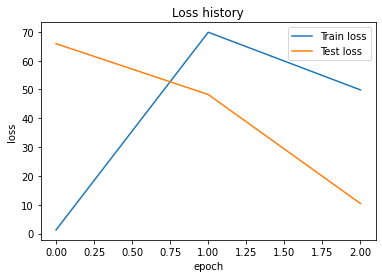


Accuracy = 46.00 %


In [ ]:

# Loss history를 그린다
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss history")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 시험 데이터로 학습 성능을 평가한다
pred = model.predict(x_test)
y_pred = np.where(pred > 0.5, 1, 0)
accuracy = (y_pred == y_test).mean()

print("\nAccuracy = %.2f %s" % (accuracy * 100, '%'))

# gpt_model.trainable = True로 바꾸고, learning-rate를 작게 적용해서
# 전체를 다시 학습한다. (미세 조정)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
# 오차행렬
print(confusion_matrix(y_test, pred))

# 정확도
print("accuracy:", accuracy_score(y_test, y_pred))

# 정밀도
print("precision:", precision_score(y_test, y_pred))

# 재현율
print("recall:", recall_score(y_test, y_pred))

# f1-score
print("F1-Score:", f1_score(y_test, y_pred))

[[ 0 54]
 [ 0 46]]
accuracy: 0.46
precision: 0.46
recall: 1.0
F1-Score: 0.6301369863013699


In [ ]:
# max_length를 줄이고
# 